In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.path import Path


For monday, plot the points of a given simulation to see if there is partisian symmetry. Assumption, we move them in two and take one from each other part. If a party is empty then both votes most move from the remaining. When going backwards we must take 2 from the party of interest and given one voter to the other two. For the function/information caluclate based on one simulation how much a given district will need to win a part. keep track of the number of total voters that moved and then how many seats are won by the movement of votes. the y will range from 0 seats to 8 seats and find when and where it changes from 0 to 1 to 2 etc. Try to find a way to enocde the information to be a variable number of districts and parties and voters. Use arrays to store the information that is needed. Distribute voters into the arrays, each indicey in an array should represent the number of districts and the votes in each segment. 

In [152]:
def voronoi_finite_polygons_2d(vor, radius=1000):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    all_ridges = {}

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 not in region:
            new_regions.append(region)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)

def sort_polygon(points):
    center = points.mean(axis=0)
    angles = np.arctan2(points[:,1] - center[1], points[:,0] - center[0])
    return points[np.argsort(angles)]


In [153]:
# ============================================================
# --- SIMULATION PARAMETERS ---
# ============================================================

WIDTH = 380
HEIGHT = 280
NUM_DISTRICTS = 8       # Number of districts
NUM_DOTS = 1000          # Number of voters
parties = 0
NUM_PARTIES = 4
cmap = plt.get_cmap('tab20')

COLORS = [cmap(i) for i in range(NUM_PARTIES)]
PARTY_IDS = [f"Party {i}" for i in range(NUM_PARTIES)]

# Dictionary mapping party name → color
PARTY_COLORS = dict(zip(PARTY_IDS, COLORS))

 # Parties (for efficiency gap and PR)
NUM_RUNS = 1          # Number of simulations

# ============================================================
# --- CREATE FIXED DISTRICT MAP (run once) ---
# ============================================================

points = np.random.rand(NUM_DISTRICTS, 2)
points[:,0] *= WIDTH
points[:,1] *= HEIGHT
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# Store fixed district polygons
district_polygons = []
for region in regions:
    polygon = vertices[region]
    if len(polygon) < 3:
        district_polygons.append(None)
    else:
        district_polygons.append(sort_polygon(polygon))


In [154]:
def run_election():
    """
    Generates random voters and counts them per district.
    Returns:
        dots_x, dots_y, dots_party_ids, district_counts
    """
    dots_x = np.random.rand(NUM_DOTS) * WIDTH
    dots_y = np.random.rand(NUM_DOTS) * HEIGHT

    # Sample party IDs instead of colors
    party_array = np.array(PARTY_IDS, dtype=object)
    dots_party_ids = np.random.choice(party_array, NUM_DOTS)

    district_counts = []
    for polygon in district_polygons:
        counts = {party: 0 for party in PARTY_IDS}

        if polygon is None:
            district_counts.append(counts)
            continue

        poly_path = Path(polygon)
        mask = poly_path.contains_points(np.column_stack((dots_x, dots_y)))

        for party, inside in zip(dots_party_ids, mask):
            if inside:
                counts[party] += 1

        district_counts.append(counts)

    return dots_x, dots_y, dots_party_ids, district_counts


In [155]:
import matplotlib.pyplot as plt

def plot_reverse_shift(results, target_party):
    history = results["history"]

    # Extract vote share and seats won
    vote_shares = [entry["vote_share"] for entry in history]
    seats_won = [entry["districts_won"] for entry in history]

    plt.figure(figsize=(8, 6))
    plt.scatter(vote_shares, seats_won, color="red", s=60)

    plt.xlabel("Statewide Vote Share (Target Party)")
    plt.ylabel("Districts Won")
    plt.title(f"Reverse Shift Seat-Vote Curve for {target_party}")

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

In [156]:
def efficiency_gc(district_counts):
    efficiency_gaps = []

    for index in range(len(district_counts)):
        district = district_counts[index]

        # Winning party
        winning_party = max(district.items(), key=lambda item: item[1])[0]
        num_winning_votes = district[winning_party]

        # Total votes in district
        num_votes_in_district = sum(district.values())

        # Losing votes
        num_losing_votes = num_votes_in_district - num_winning_votes

        # Wasted votes
        wasted_winner = num_winning_votes - (num_votes_in_district / NUM_PARTIES)
        wasted_loser = num_losing_votes

        # Efficiency gap for this district
        efficiency_gap = (wasted_winner - wasted_loser) / num_votes_in_district
        efficiency_gaps.append(efficiency_gap)

    return efficiency_gaps


In [157]:
def calculate_PR(district_counts):
    """
    Returns a dictionary of allocated seats per party using largest remainder method.
    """
    NUM_SEATS = NUM_DISTRICTS

    # Compute statewide votes
    statewide_votes = {party: 0 for party in PARTY_IDS}
    for district in district_counts:
        for party in PARTY_IDS:
            statewide_votes[party] += district[party]

    total_votes = sum(statewide_votes.values())
    exact_seats = {
        party: (statewide_votes[party] / total_votes) * NUM_SEATS
        for party in PARTY_IDS
    }

    # Assign integer seats first
    allocated_seats = {party: int(exact_seats[party]) for party in PARTY_IDS}
    remaining_seats = NUM_SEATS - sum(allocated_seats.values())

    # Largest remainder method
    remainders = {
        party: exact_seats[party] - allocated_seats[party]
        for party in PARTY_IDS
    }
    sorted_by_remainder = sorted(PARTY_IDS, key=lambda p: remainders[p], reverse=True)

    for i in range(remaining_seats):
        allocated_seats[sorted_by_remainder[i]] += 1

    return statewide_votes, allocated_seats


In [158]:
# ============================================================
# --- RUN SIMULATIONS ---
# ============================================================

all_results = []

for run in range(NUM_RUNS):
    dots_x, dots_y, dots_party_ids, district_counts = run_election()
    statewide_votes, allocated_seats = calculate_PR(district_counts)
    efficiency_gaps = efficiency_gc(district_counts)

    all_results.append({
        'statewide_votes': statewide_votes,
        'allocated_seats': allocated_seats,
        'dots_x': dots_x,
        'dots_y': dots_y,
        'dots_party_ids': dots_party_ids,
        'district_counts': district_counts,      # ← add this
        'efficiency_gaps': efficiency_gaps
    })


In [159]:
def simulate_vote_shifts(district_counts, target_party):
    """
    Simulates shifting voters toward the target party until it wins all districts
    or no competitor voters remain.

    district_counts: list of dicts {party_id: votes}
    target_party: string, e.g. "Party 0"

    Returns:
        {
            "shifts": total_shifts,
            "history": [
                {"shift": n, "districts_won": k, "vote_share": v},
                ...
            ],
            "final_district_counts": updated_counts
        }
    """

    # Make a deep copy so we don't mutate the original
    import copy
    counts = copy.deepcopy(district_counts)

    

    competitors = [p for p in PARTY_IDS if p != target_party]
    voters_per_district = len(competitors)   # = NUM_PARTIES - 1

    def district_winner(d):
        return max(d, key=d.get)

    def count_target_wins():
        return sum(1 for d in counts if district_winner(d) == target_party)

    def statewide_vote_share():
        total = 0
        target_total = 0
        for d in counts:
            for p, v in d.items():
                total += v
                if p == target_party:
                    target_total += v
        return target_total / total if total > 0 else 0

    # Initial state
    current_wins = count_target_wins()
    history = []
    shift_number = 0
    initial_wins = count_target_wins()
    initial_share = statewide_vote_share()
    print(f"Initial: {target_party} wins {current_wins} out of {NUM_DISTRICTS} districts")

    # Main loop
    while True:
        shift_number += 1
        print(f"\n=== SHIFT {shift_number} ===")

        any_competitor_left = False

        # Apply shift to each district
        for i, d in enumerate(counts):
            moved = 0

            # Check if district has any competitor voters
            competitor_votes = sum(d[p] for p in competitors)
            if competitor_votes == 0:
                print(f"District {i}: skipped (no competitor voters)")
                continue

            any_competitor_left = True

            # Try to remove 1 voter from each competitor
            for p in competitors:
                if d[p] > 0:
                    d[p] -= 1
                    moved += 1

            # Add all removed voters to target party
            d[target_party] += moved

            print(f"District {i}: moved {moved} voters → {target_party} now has {d[target_party]}")

        # If no competitor voters remain anywhere, stop
        if not any_competitor_left:
            print("\nNo competitor voters remain anywhere. Stopping simulation.")
            break

        # Recompute district wins
        new_wins = count_target_wins()

        if new_wins > current_wins:
            share = statewide_vote_share()
            print(f"\n{target_party} now wins {new_wins} districts (+{new_wins - current_wins})")
            print(f"Statewide vote share: {share*100:.2f}%")

            history.append({
                "shift": shift_number,
                "districts_won": new_wins,
                "vote_share": share
            })

            current_wins = new_wins

        else:
            print(f"{target_party} wins {new_wins} districts (no change)")

        # Stop if target party wins all districts
        if new_wins == NUM_DISTRICTS:
            print(f"\n{target_party} now wins ALL {NUM_DISTRICTS} districts. Simulation complete.")
            break

    return {
    "shifts": shift_number,
    "history": history,
    "final_district_counts": counts,
    "initial_wins": initial_wins,
    "initial_vote_share": initial_share
}



In [160]:
def simulate_reverse_shifts(district_counts, target_party):
    """
    Reverse simulation:
    Removes voters from the target party and distributes them evenly
    to all competitor parties. Continues until the target party wins 0 districts
    or has no voters left to remove.

    Returns:
        {
            "shifts": total_shifts,
            "history": [...],
            "final_district_counts": counts
        }
    """

    import copy
    counts = copy.deepcopy(district_counts)
    
    competitors = [p for p in PARTY_IDS if p != target_party]
    voters_per_district = len(competitors)  # remove this many from target

    def district_winner(d):
        return max(d, key=d.get)

    def count_target_wins():
        return sum(1 for d in counts if district_winner(d) == target_party)

    def statewide_vote_share():
        total = 0
        target_total = 0
        for d in counts:
            for p, v in d.items():
                total += v
                if p == target_party:
                    target_total += v
        return target_total / total if total > 0 else 0

    # Initial state
    initial_wins = count_target_wins()
    initial_share = statewide_vote_share()
    current_wins = count_target_wins()
    history = []
    shift_number = 0

    print(f"Initial: {target_party} wins {current_wins} out of {NUM_DISTRICTS} districts")

    while True:
        shift_number += 1
        print(f"\n=== REVERSE SHIFT {shift_number} ===")

        any_target_votes_left = False

        for i, d in enumerate(counts):
            moved = 0

            # If target party has no votes, skip
            if d[target_party] == 0:
                print(f"District {i}: skipped (no {target_party} voters left)")
                continue

            any_target_votes_left = True

            # Remove 1 vote per competitor (total = voters_per_district)
            for _ in competitors:
                if d[target_party] > 0:
                    d[target_party] -= 1
                    moved += 1

            # Distribute removed votes evenly: 1 to each competitor
            for p in competitors:
                d[p] += 1

            print(f"District {i}: removed {moved} from {target_party} → distributed to competitors")

        if not any_target_votes_left:
            print("\nNo target-party voters remain anywhere. Stopping simulation.")
            break

        # Recompute district wins
        new_wins = count_target_wins()

        if new_wins < current_wins:
            share = statewide_vote_share()
            print(f"\n{target_party} now wins {new_wins} districts (-{current_wins - new_wins})")
            print(f"Statewide vote share: {share*100:.2f}%")

            history.append({
                "shift": shift_number,
                "districts_won": new_wins,
                "vote_share": share
            })

            current_wins = new_wins
        else:
            print(f"{target_party} still wins {new_wins} districts (no change)")

        if new_wins == 0:
            print(f"\n{target_party} now wins ZERO districts. Simulation complete.")
            break

    return {
    "shifts": shift_number,
    "history": history,
    "final_district_counts": counts,
    "initial_wins": initial_wins,
    "initial_vote_share": initial_share
    }
    

    


In [ ]:
#------------------------------------------------------------------------------
#CODE TO PLOT BOTH THE FORWARD SHIFT AND REVERSE SHIFT ON THE SAME GRIDLINES
#-------------------------------------------------------------------------------

import matplotlib.pyplot as plt

def plot_forward_and_reverse_step(results_fwd, results_rev, target_party):
    # Extract initial values
    initial_vote = results_fwd["initial_vote_share"]
    initial_seats = results_fwd["initial_wins"]

    # FORWARD DATA
    fwd_history = results_fwd["history"]
    fwd_vote = [initial_vote] + [h["vote_share"] for h in fwd_history]
    fwd_seats = [initial_seats] + [h["districts_won"] for h in fwd_history]

    # REVERSE DATA
    rev_history = results_rev["history"]
    rev_vote = [initial_vote] + [h["vote_share"] for h in rev_history]
    rev_seats = [initial_seats] + [h["districts_won"] for h in rev_history]

    # MERGE + SORT
    merged = list(zip(fwd_vote, fwd_seats)) + list(zip(rev_vote, rev_seats))
    merged = sorted(set(merged))

    x, y = zip(*merged)

    # ⭐ EXTEND THE CURVE TO THE EDGES
    left_x = min(x) - 0.02
    right_x = max(x) + 0.02

    # Extend using the first and last y-values
    x_extended = (left_x,) + x + (right_x,)
    y_extended = (y[0],) + y + (y[-1],)

    # PLOT
    plt.figure(figsize=(10, 6))

    plt.step(
        x_extended, y_extended,
        where="post",
        color="black",
        linewidth=2
    )
    plt.scatter(x, y, color="black")

    # Nice axis padding
    plt.xlim(left_x, right_x)

    plt.xlabel("Statewide Vote Share (Target Party)")
    plt.ylabel("Districts Won")
    plt.title(f"Seat–Vote Step Curve for {target_party}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


In [162]:
#DATE TRANSFORM AND COMPLEMENT GRAPHING



# Extract initial values
initial_vote = results_fwd["initial_vote_share"]
initial_seats = results_fwd["initial_wins"]

# Forward data
fwd_history = results_fwd["history"]
fwd_vote = [initial_vote] + [entry["vote_share"] for entry in fwd_history]
fwd_seats = [initial_seats] + [entry["districts_won"] for entry in fwd_history]

# Reverse data
rev_history = results_rev["history"]
rev_vote = [initial_vote] + [entry["vote_share"] for entry in rev_history]
rev_seats = [initial_seats] + [entry["districts_won"] for entry in rev_history]

import matplotlib.pyplot as plt

def plot_complement_step(fwd_vote, fwd_seats, rev_vote, rev_seats, target_party):
    # Complement transform
    fwd_vote_c = [1 - v for v in fwd_vote]
    fwd_seats_c = [NUM_DISTRICTS - s for s in fwd_seats]

    rev_vote_c = [1 - v for v in rev_vote]
    rev_seats_c = [NUM_DISTRICTS - s for s in rev_seats]


    # --- FIX: Sort both curves by x-axis so they connect ---
    fwd_sorted = sorted(zip(fwd_vote_c, fwd_seats_c))
    rev_sorted = sorted(zip(rev_vote_c, rev_seats_c))

    fwd_vote_c, fwd_seats_c = zip(*fwd_sorted)
    rev_vote_c, rev_seats_c = zip(*rev_sorted)


    plt.figure(figsize=(10, 6))

    # Forward complement step
    plt.step(
        fwd_vote_c, fwd_seats_c,
        where="post",
        color="blue",
        linewidth=2,
        label="Forward Complement"
    )

    # Reverse complement step
    plt.step(
        rev_vote_c, rev_seats_c,
        where="post",
        color="red",
        linewidth=2,
        label="Reverse Complement"
    )

    # Scatter points
    plt.scatter(fwd_vote_c, fwd_seats_c, color="blue")
    plt.scatter(rev_vote_c, rev_seats_c, color="red")

    plt.xlabel("1 - Vote Share (Opposition Vote Share)")
    plt.ylabel(f"{NUM_DISTRICTS} - Seats Won (Seats Lost)")
    plt.title(f"Complement Seat–Vote Curve for {target_party}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()


In [174]:
#-----------------------------
#PRINT THE COMPLEMENT DATA 
#------------------------------


def plot_complement_step(results_fwd, results_rev, target_party):
    initial_vote = results_fwd["initial_vote_share"]
    initial_seats = results_fwd["initial_wins"]

    # Forward
    fwd = [(initial_vote, initial_seats)] + [
        (h["vote_share"], h["districts_won"]) for h in results_fwd["history"]
    ]

    # Reverse
    rev = [(initial_vote, initial_seats)] + [
        (h["vote_share"], h["districts_won"]) for h in results_rev["history"]
    ]

    # Merge + sort
    merged = sorted(set(fwd + rev))

    # Complement transform
    comp = [(1 - v, NUM_DISTRICTS - s) for v, s in merged]
    comp = sorted(comp)

    x, y = zip(*comp)

    # Extend edges
    left_x = min(x) - 0.02
    right_x = max(x) + 0.02
    x_ext = (left_x,) + x + (right_x,)
    y_ext = (y[0],) + y + (y[-1],)

    plt.figure(figsize=(10,6))
    plt.step(x_ext, y_ext, where="post", color="black", linewidth=2)
    plt.scatter(x, y, color="black")

    plt.xlim(left_x, right_x)
    plt.xlabel("Opposition Vote Share (1 - v)")
    plt.ylabel("Seats Lost (8 - seats)")
    plt.title(f"Complement Seat–Vote Curve for {target_party}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


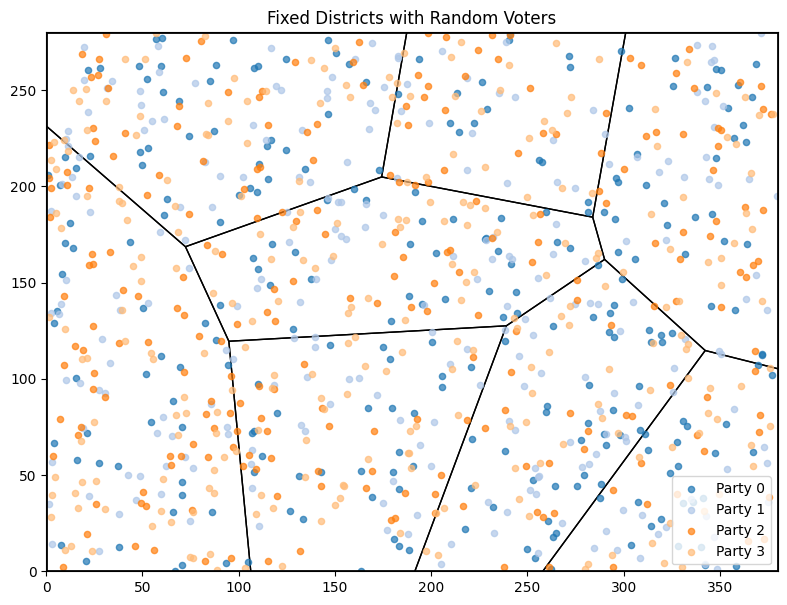

After loop, len(all_results) = 1

--- Simulation 1 ---
Statewide votes: {'Party 0': 254, 'Party 1': 245, 'Party 2': 239, 'Party 3': 262}
Party 0 Vote/Total Vote: 0.254
Party 1 Vote/Total Vote: 0.245
Party 2 Vote/Total Vote: 0.239
Party 3 Vote/Total Vote: 0.262
District 1: {'Party 0': 30, 'Party 1': 29, 'Party 2': 29, 'Party 3': 36}
District 2: {'Party 0': 38, 'Party 1': 44, 'Party 2': 56, 'Party 3': 58}
District 3: {'Party 0': 39, 'Party 1': 41, 'Party 2': 34, 'Party 3': 35}
District 4: {'Party 0': 25, 'Party 1': 18, 'Party 2': 15, 'Party 3': 21}
District 5: {'Party 0': 40, 'Party 1': 40, 'Party 2': 21, 'Party 3': 28}
District 6: {'Party 0': 32, 'Party 1': 30, 'Party 2': 29, 'Party 3': 39}
District 7: {'Party 0': 17, 'Party 1': 17, 'Party 2': 22, 'Party 3': 22}
District 8: {'Party 0': 33, 'Party 1': 26, 'Party 2': 33, 'Party 3': 23}
Allocated seats: {'Party 0': 2, 'Party 1': 2, 'Party 2': 2, 'Party 3': 2}
Efficiency Gap: [-0.6693548387096774, -0.6581632653061225, -0.6996644295302014, -

In [ ]:
# ============================================================
# ---  visualize one run ---
# ============================================================

run_to_show = 0
dots_x = all_results[run_to_show]['dots_x']
dots_y = all_results[run_to_show]['dots_y']
dots_party_ids = all_results[run_to_show]['dots_party_ids']   # UPDATED

fig, ax = plt.subplots(figsize=(10,7))

# Draw district boundaries
for polygon in district_polygons:
    if polygon is not None:
        ax.fill(polygon[:,0], polygon[:,1], edgecolor='black', fill=False, linewidth=1)

# Plot voters by party
for party in PARTY_IDS:
    party_mask = (dots_party_ids == party)
    party_color = PARTY_COLORS[party]

    ax.scatter(
        dots_x[party_mask],
        dots_y[party_mask],
        c=[party_color],
        label=party,
        s=20,
        alpha=0.7
    )

# Draw bounding box
ax.plot([0, WIDTH, WIDTH, 0, 0], [0,0,HEIGHT,HEIGHT,0], color='black', linewidth=2)
ax.set_xlim(0, WIDTH)
ax.set_ylim(0, HEIGHT)
ax.set_aspect('equal')
ax.set_title('Fixed Districts with Random Voters')
ax.legend()
plt.show()
# ============================================================
# --- SHOW RESULTS ---
# ============================================================
print("After loop, len(all_results) =", len(all_results))

arr=[]
for i, result in enumerate(all_results[:1000]):
    print(f"\n--- Simulation {i+1} ---")
    
    statewide = result['statewide_votes']
    total_votes = sum(statewide.values())

    print("Statewide votes:", statewide)

    # Print each party's vote share
    for party, votes in statewide.items():
        print(f"{party} Vote/Total Vote:", votes / total_votes)

    # Print district counts for this run
    for d, counts in enumerate(result['district_counts']):
        print(f"District {d+1}: {counts}")

    print("Allocated seats:", result['allocated_seats'])
    print("Efficiency Gap:", result['efficiency_gaps'])

    gaps = result['efficiency_gaps']
    std_gap = np.std(gaps)
    print("Std Dev of Efficiency Gaps:", std_gap)

    arr.append(std_gap)



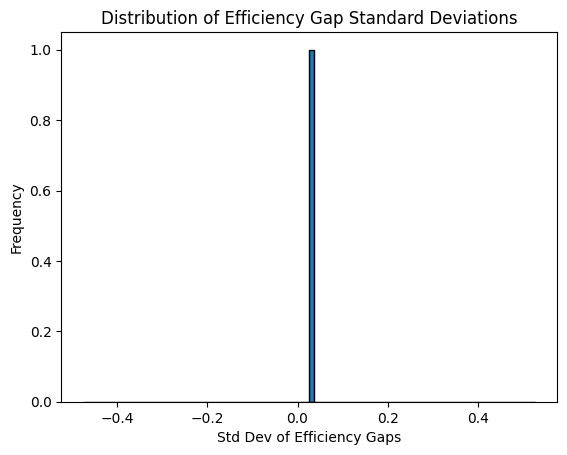

In [165]:
plt.hist(arr, bins=100, edgecolor='black')
plt.xlabel("Std Dev of Efficiency Gaps")
plt.ylabel("Frequency")
plt.title("Distribution of Efficiency Gap Standard Deviations")
plt.show()

Initial: Party 0 wins 3 out of 8 districts

=== SHIFT 1 ===
District 0: moved 3 voters → Party 0 now has 33
District 1: moved 3 voters → Party 0 now has 41
District 2: moved 3 voters → Party 0 now has 42
District 3: moved 3 voters → Party 0 now has 28
District 4: moved 3 voters → Party 0 now has 43
District 5: moved 3 voters → Party 0 now has 35
District 6: moved 3 voters → Party 0 now has 20
District 7: moved 3 voters → Party 0 now has 36

Party 0 now wins 4 districts (+1)
Statewide vote share: 27.80%

=== SHIFT 2 ===
District 0: moved 3 voters → Party 0 now has 36
District 1: moved 3 voters → Party 0 now has 44
District 2: moved 3 voters → Party 0 now has 45
District 3: moved 3 voters → Party 0 now has 31
District 4: moved 3 voters → Party 0 now has 46
District 5: moved 3 voters → Party 0 now has 38
District 6: moved 3 voters → Party 0 now has 23
District 7: moved 3 voters → Party 0 now has 39

Party 0 now wins 7 districts (+3)
Statewide vote share: 30.20%

=== SHIFT 3 ===
District 0

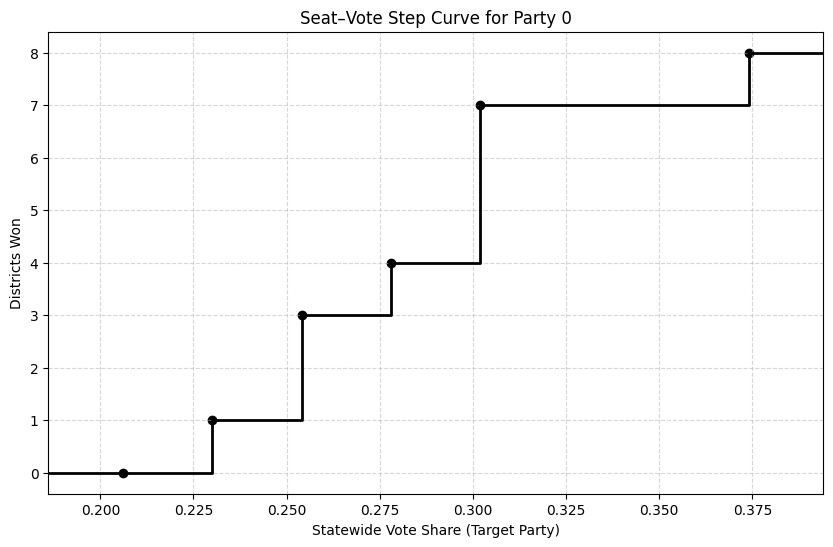

In [169]:
results_fwd = simulate_vote_shifts(district_counts, target_party="Party 0")
results_rev = simulate_reverse_shifts(district_counts, target_party="Party 0")

plot_forward_and_reverse_step(results_fwd, results_rev, target_party="Party 0")


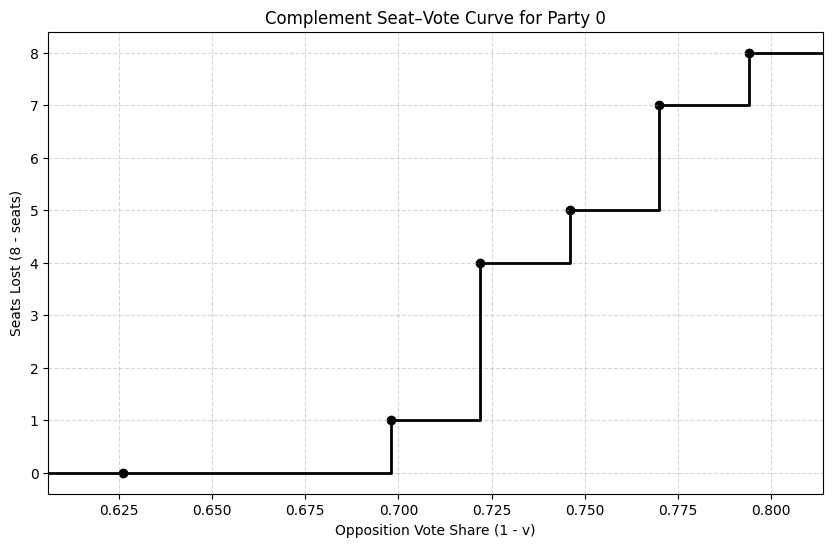

In [179]:

plot_complement_step(results_fwd,results_rev,target_party="Party 0")